In [1]:
import numpy as np
import torch
import time
from time import time as timer_start
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model,get_cnn_lstm_ae_model,make_train_X,sliding_window_mult_feat
from Detectors.Deep_Learning.AutoEncoders.utils import get_loss_filter_indiv as loss_smooth
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder
import flow.visualize.visualize_ring as visualize_ring
from flow.visualize.visualize_ring import get_measured_leader,get_rel_dist_to_measured_leader,get_vel_of_measured_leader
from copy import deepcopy
import sys
import utils
from utils import assess_relative_model_on_attack
import ray
import os
import csv
from sklearn.metrics import roc_curve,auc



In [4]:
from importlib import reload
import proccess_i24_losses
reload(proccess_i24_losses)

from proccess_i24_losses import get_sim_timeseries,get_rec_errors,get_sim_timeseries_all_data,get_losses_csv

In [3]:
# csv_path = '/Volumes/My Passport for Mac/i24_random_sample/simulations/Dur_19.15043308018294_Mag_-1.755389161086853_Inflow_1800_ACCPenetration_0.2_AttackPenetration_0.1_ver_1.csv'
csv_path = '/Volumes/My Passport for Mac/misc/Dur_45_Mag_-1.0_Inflow_1800_ACCPenetration_0.2_AttackPenetration_0.1_ver_1.csv'
warmup_period = 1200
sim_timeseries = get_sim_timeseries(csv_path,warmup_period)

Data loaded, total time: 35.84037899971008


In [5]:
model = get_cnn_lstm_ae_model(n_features=4)
# Load in a trained model:
MODEL_PATH = os.path.join(os.getcwd(),'models/cnn_lstm_ae_i24_detector_complete_obs_ver2.pt')
model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu')))

rec_error_dict = get_rec_errors(sim_timeseries,model,warmup_period=warmup_period)

print('Finished finding reconstruction errors.')

Vehicles processed: 100/1523, total compute time: 57.78901195526123
Vehicles processed: 200/1523, total compute time: 180.14569091796875
Vehicles processed: 300/1523, total compute time: 378.2386999130249
Vehicles processed: 400/1523, total compute time: 572.3673498630524
Vehicles processed: 500/1523, total compute time: 768.4057641029358
Vehicles processed: 600/1523, total compute time: 971.7772200107574
Vehicles processed: 700/1523, total compute time: 1181.9216809272766
Vehicles processed: 800/1523, total compute time: 1411.5731909275055
Vehicles processed: 900/1523, total compute time: 1625.6062579154968
Vehicles processed: 1000/1523, total compute time: 1819.4603140354156
Vehicles processed: 1100/1523, total compute time: 2019.5405440330505
Vehicles processed: 1200/1523, total compute time: 2170.5184030532837
Vehicles processed: 1300/1523, total compute time: 2287.907747030258
Vehicles processed: 1400/1523, total compute time: 2373.1663620471954
Vehicles processed: 1500/1523, tota

In [6]:
from proccess_i24_losses import write_losses_to_file

file_name = '/Volumes/My Passport for Mac/misc/Dur_45_Mag_-1.0_Inflow_1800_ae_rec_errors_seqlen_100.csv'
write_losses_to_file(rec_error_dict,file_name)
print('Wrote file.')

Loss file written to csv.
Wrote file.


In [ ]:
all_sim_data = get_sim_timeseries_all_data(csv_path,warmup_period=warmup_period)

In [21]:
id_index = 0
time_index = 0
speed_index = 0
headway_index = 0
relvel_index = 0
edge_index = 0
pos_index = 0
lane_index = 0

with open(csv_path, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    row1 = next(csvreader)
    print(row1)
    
    edge_list = ['Eastbound_3',':202186118','Eastbound_4','Eastbound_5','Eastbound_6',':202186134','Eastbound_7']

    row1 = next(csvreader)
    num_entries = len(row1)
    while(row1[id_index]!='id' and id_index<num_entries):id_index +=1
    while(row1[edge_index]!='edge_id' and edge_index<num_entries):edge_index +=1
    while(row1[time_index]!='time' and time_index<num_entries):time_index +=1
    while(row1[speed_index]!='speed' and speed_index<num_entries):speed_index +=1
    while(row1[headway_index]!='headway' and headway_index<num_entries):headway_index +=1
    while(row1[relvel_index]!='leader_rel_speed' and relvel_index<num_entries):relvel_index +=1
    while(row1[lane_index]!='lane_number'and lane_index<num_entries):lane_index +=1

    
    

['time', 'id', 'type', 'x', 'y', 'speed', 'headway', 'leader_id', 'follower_id', 'leader_rel_speed', 'target_accel_with_noise_with_failsafe', 'target_accel_no_noise_no_failsafe', 'target_accel_with_noise_no_failsafe', 'target_accel_no_noise_with_failsafe', 'realized_accel', 'road_grade', 'edge_id', 'lane_number', 'distance', 'relative_position']


IndexError: list index out of range

In [22]:
human_main_only_max_rec_error = []
human_main_off_ramp_max_rec_error = []
human_on_ramp_main_max_rec_error = []
human_on_ramp_off_ramp_max_rec_error = []

acc_benign_max_rec_error = []
acc_attack_max_rec_error = []

veh_types = []

for veh_id in rec_error_dict:
    rec_error = np.array(rec_error_dict[veh_id])
    rec_error = rec_error[1,:]
    max_rec_error = np.max(rec_error)
    veh_type = all_sim_data[veh_id][0][2]
    
    if('human_main' == veh_type):
        end_edge = all_sim_data[veh_id][-1][-4]
        end_lane = all_sim_data[veh_id][-1][-3]
        
        is_main_only = end_edge=='Eastbound_7' and end_lane != '0'
        is_main_off_ramp = end_edge=='Eastbound_7' and end_lane == '0'
        if(is_main_only):
            human_main_only_max_rec_error.append(max_rec_error)
        else:
            human_main_off_ramp_max_rec_error.append(max_rec_error)
        
    elif('human_on_ramp' == veh_type):
        human_on_ramp_max_rec_error.append(max_rec_error)
        
        end_edge = all_sim_data[veh_id][-1][-4]
        end_lane = all_sim_data[veh_id][-1][-3]
        
        is_main = end_edge=='Eastbound_7' and end_lane != '0'
        is_off_ramp = end_edge=='Eastbound_7' and end_lane == '0'
        if(is_main):
            human_on_ramp_main_max_rec_error.append(max_rec_error)
        else:
            human_on_ramp_off_ramp_max_rec_error.append(max_rec_error)
        
        
        
    elif(veh_type == 'benign_ACC'):
        acc_benign_max_rec_error.append(max_rec_error)
    elif(veh_type == 'attacker_ACC'):
        acc_attack_max_rec_error.append(max_rec_error)
        
        
print('Finished sorting max rec errors.')

Finished sorting max rec errors.


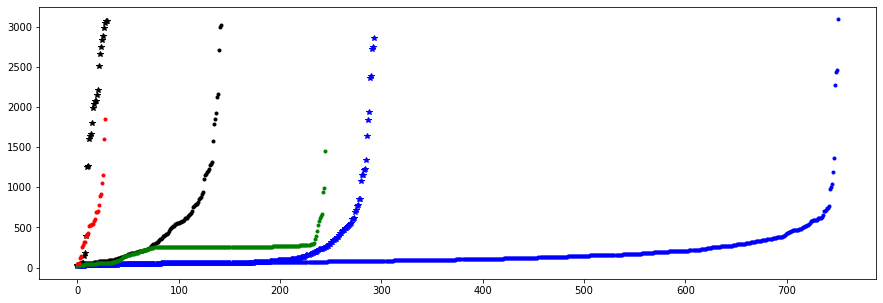

In [23]:
plt.figure(figsize=[15,5])
plt.plot(np.sort(human_main_only_max_rec_error),'b.')
plt.plot(np.sort(human_main_off_ramp_max_rec_error),'b*')

plt.plot(np.sort(human_on_ramp_main_max_rec_error),'k.')
plt.plot(np.sort(human_on_ramp_off_ramp_max_rec_error),'k*')


plt.plot(np.sort(acc_benign_max_rec_error),'g.')
plt.plot(np.sort(acc_attack_max_rec_error),'r.')

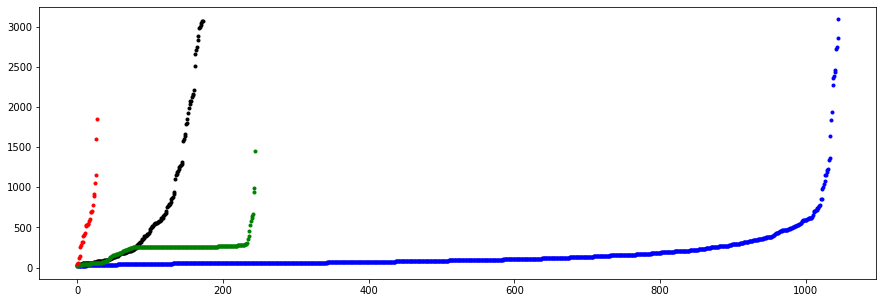

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=[15,5])
plt.plot(np.sort(human_main_max_rec_error),'b.')
plt.plot(np.sort(human_on_ramp_max_rec_error),'k.')
plt.plot(np.sort(acc_benign_max_rec_error),'g.')
plt.plot(np.sort(acc_attack_max_rec_error),'r.')

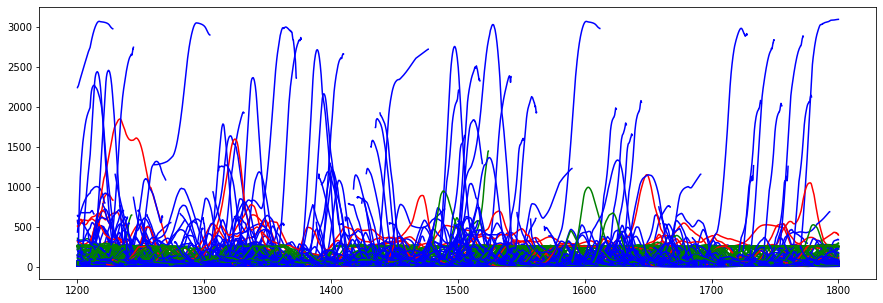

In [16]:
plt.figure(figsize=[15,5])

for veh_id in rec_error_dict:
    rec_error = np.array(rec_error_dict[veh_id])
    times = rec_error[0,:]
    rec_error = rec_error[1,:]
    
    veh_type = all_sim_data[veh_id][0][2]
    if('human_main' == veh_type):
        plt.plot(times,rec_error,'b')
    elif(veh_type == 'benign_ACC'):
        plt.plot(times,rec_error,'g')
    elif(veh_type == 'attacker_ACC'):
        plt.plot(times,rec_error,'r')

ValueError: x and y must be the same size

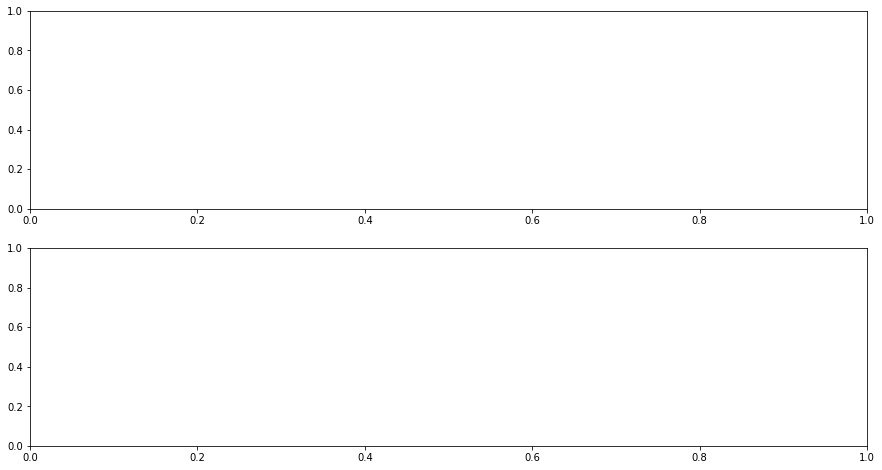

In [28]:
plt.figure(figsize=[15,8])
plt.subplot(2,1,1)

for veh_id in rec_error_dict:
    rec_error = np.array(rec_error_dict[veh_id])
    times = rec_error[0,:]
    rec_error = rec_error[1,:]
    veh_type = all_sim_data[veh_id][0][2]
    
    vehicle_timeseries_data = sim_timeseries[veh_id]
    speeds = vehicle_timeseries_data[:,1]
    
    if(veh_type == 'benign_ACC'):
#         plt.plot(times,rec_error,'g')
        plt.subplot(2,1,1)
        plt.scatter(time,speeds,c=rec_error)
    elif(veh_type == 'attacker_ACC'):
#         plt.plot(times,rec_error,'r')
        plt.subplot(2,1,2)
        plt.scatter(time,speeds,c=rec_error)


In [ ]:
import SumoNetVis
# net = SumoNetVis.Net('/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/examples/exp_configs/templates/sumo/i24_subnetwork_fix_merges.net.xml')

# import flow.visualize.visualize_ring
# from importlib import reload
# reload(flow.visualize.visualize_ring)
# from flow.visualize.visualize_ring import get_sim_timeseries_all_data

import proccess_i24_losses
reload(proccess_i24_losses)

from proccess_i24_losses import get_sim_timeseries_all_data

all_sim_data = get_sim_timeseries_all_data(csv_path,warmup_period=warmup_period)

In [ ]:
rec_error_dict = deepcopy(losses)
for veh_id in rec_error_dict:
    rec_error_dict[veh_id] = np.array(rec_error_dict[veh_id]).T

max_rec_error_vals = []
max_rec_error_locations = []
max_rec_error_speeds = []
max_rec_error_speed_differences = []
max_rec_error_spacings = []
max_rec_veh_ids = []

for veh_id in veh_ids:
    all_veh_data = all_sim_data[veh_id]
    rec_errors = rec_error_dict[veh_id][:,1]
    
    max_rec_veh_ids.append(veh_id)
    
    max_rec_error = rec_errors[0]
    temp = 0
    for i in range(1,len(rec_errors)):
        if(rec_errors[i] > max_rec_error):
            temp = i
            max_rec_error = rec_errors[i]
    max_rec_error_vals.append(max_rec_error)
    x = float(all_veh_data[temp][3])
    y = float(all_veh_data[temp][4])
    v = float(all_veh_data[temp][5])
    s = float(all_veh_data[temp][6])
    dv = float(all_veh_data[temp][9])
    max_rec_error_locations.append([x,y])
    max_rec_error_speeds.append(v)
    max_rec_error_speed_differences.append(dv)
    max_rec_error_spacings.append(s)
    
print('Finished.')

In [ ]:
non_empty_leader_max_rec_error_indices = []
for i in range(len(max_rec_error_vals)):
    if(max_rec_error_vals[i] > 200):
#         print(max_rec_error_vals[i])
        non_empty_leader_max_rec_error_indices.append(i)

max_rec_error_locations = np.array(max_rec_error_locations)
max_rec_error_vals = np.array(max_rec_error_vals)

# x_vals = max_rec_error_locations[:,0]
# y_vals = max_rec_error_locations[:,1]
# color = max_rec_error_vals

x_vals = max_rec_error_locations[non_empty_leader_max_rec_error_indices,0]
y_vals = max_rec_error_locations[non_empty_leader_max_rec_error_indices,1]
color = max_rec_error_vals[non_empty_leader_max_rec_error_indices]

plt.figure(figsize=[15,8])

net = SumoNetVis.Net('/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/examples/exp_configs/templates/sumo/i24_subnetwork_fix_merges.net.xml')

net.plot()

plt.scatter(x_vals,y_vals,c=color)
plt.colorbar()

#Zoomed in to end of the network:
# plt.ylim([20000,20700])
# plt.xlim([6800,7700])

plt.ylim([19900,20100])
plt.xlim([7600,7800])

#For full network
# plt.ylim([19000,21500])
# plt.xlim([5500,8200])

In [ ]:
human_max_losses = []
acc_benign_max_losses = []
acc_attack_max_losses = []

veh_types = []
for veh_id in rec_error_dict:
    loss = rec_error_dict[veh_id][:,1]
    max_loss = np.max(loss)
    veh_type = all_sim_data[veh_id][0][2]
    if('human' in veh_type):
        human_max_losses.append(max_loss)
    elif(veh_type == 'benign_ACC'):
        acc_benign_max_losses.append(max_loss)
    elif(veh_type == 'attacker_ACC'):
        acc_attack_max_losses.append(max_loss)
print('Finished')

In [ ]:
plt.figure(figsize=[15,5])
plt.plot(np.sort(human_max_losses),'b.')
plt.plot(np.sort(acc_benign_max_losses),'g.')
plt.plot(np.sort(acc_attack_max_losses),'r.')

In [ ]:
human_mean_losses = []
acc_benign_mean_losses = []
acc_attack_mean_losses = []

veh_types = []
for veh_id in rec_error_dict:
    loss = rec_error_dict[veh_id][:,1]
    mean_loss = np.mean(loss)
    veh_type = all_sim_data[veh_id][0][2]
    if('human' in veh_type):
        human_mean_losses.append(mean_loss)
    elif(veh_type == 'benign_ACC'):
        acc_benign_mean_losses.append(mean_loss)
    elif(veh_type == 'attacker_ACC'):
        acc_attack_mean_losses.append(mean_loss)
        
print('Finished')

plt.figure(figsize=[15,5])
plt.plot(np.sort(human_mean_losses),'b.')
plt.plot(np.sort(acc_benign_mean_losses),'g.')
plt.plot(np.sort(acc_attack_mean_losses),'r.')